# Sea Surface Temperature Bias - NOAA OISSTv2

This notebook plots the SST bias of a model simulation vs. climataology derived from NOAA OISSTv2

In [1]:
# For testing and development purposes, enter a start year, end year, and
# an dora id number to analyze. The value of dora_id can also be a direct
# path to a /pp directory.

config = {
    "startyr": None,
    "endyr": None,
    "dora_id": "odiv-413",
}

In [2]:
# Make sure this cell is active so that the workflow and Dora can update
# the config dictionary at runtime.

from gfdlnb.tools.update_notebook_config import update_notebook_config
config = update_notebook_config(config)

In [3]:
print(str(config))

{'startyr': None, 'endyr': None, 'dora_id': 'odiv-413'}


### Import Python Modules

In [4]:
import doralite
import glob
import momlevel
import subprocess
import os
import datetime

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import ListedColormap, BoundaryNorm

In [5]:
# momgrid will use a directory of pre-computed weights that is used for calculating basic area-weighted statistics later
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Definie Local Parameters

In [6]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

if config["dora_id"] is not None:
    experiment =  doralite.dora_metadata(config["dora_id"])
    pathPP = experiment["pathPP"]
    expName = experiment["expName"]
else:
    raise ValueError("Experiment must be defined")

# Define start and end years
start = config["startyr"]
start = int(start) if start is not None else 1

end = config["endyr"]
end = int(start) if end is not None else 9999

### Determine What Files to Load

In [7]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_monthly"
static = f"{component}/{component}.static.nc"
varname = "tos"

chunk = "5yr"
filelist = sorted(glob.glob(f"{pathPP}{component}/ts/**/{chunk}/{component}.*.{varname}.nc", recursive=True))

def is_in_range(file,start,end):
    start = 1 if start is None else start
    end = 9999 if end is None else end
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

filelist = [x for x in filelist if is_in_range(x,start,end)]
staticfile = f"{pathPP}/{static}"

_ = [print(x) for x in filelist]

/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.000101-000512.tos.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.000601-001012.tos.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.001101-001512.tos.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.001601-002012.tos.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/ocean_monthly/ts/monthly/5yr/ocean_monthly.002101-002512.tos.nc
/archive/John.Krasting/fre/FMS2024.02_OM5_20240724/CM4.5v01_om5b06_piC_noBLING/gfdl.ncrc5-intel23-prod-openmp/pp/oc

### DMgetting Files

Dora cannot issue calls to dmget

In [8]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+[staticfile]
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [9]:
ds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
model_type = ds.model
ds = ds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

In [10]:
ds

<xarray.Dataset>
Dimensions:     (time: 660, nv: 2, xh: 1440, yh: 1161, yq: 1162, xq: 1441)
Coordinates:
  * time        (time) object 0001-01-16 12:00:00 ... 0060-12-16 12:00:00
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.438e+03 1.44e+03
  * yh          (yh) float64 0.5 1.5 2.5 3.5 ... 1.158e+03 1.16e+03 1.16e+03
    geolon      (yh, xh) float32 -299.9 -299.6 -299.4 -299.1 ... 60.0 60.0 60.0
    geolat      (yh, xh) float32 -88.52 -88.52 -88.52 ... 64.33 64.22 64.11
    areacello   (yh, xh) float32 7.708e+06 7.708e+06 ... 2.384e+06 1.201e+06
  * xq          (xq) float64 1.0 2.0 3.0 4.0 ... 1.439e+03 1.44e+03 1.441e+03
  * yq          (yq) float64 1.0 2.0 3.0 4.0 ... 1.16e+03 1.161e+03 1.162e+03
Data variables:
    average_DT  (time) timedelta64[ns] dask.array<chunksize=(60,), meta=np.ndarray>
    average_T1  (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    average_T2  (time) object dask.array<chunksize=(60,), meta=np.ndarray>
    time_bnds   (time, nv) object dask.array<chunksize=(60, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 dask.array<chunksize=(60, 1161, 1440), meta=np.ndarray>
    geolon_c    (yq, xq) float32 -300.0 -299.8 -299.5 -299.2 ... 60.0 60.0 60.0
    geolat_c    (yq, xq) float32 -88.57 -88.57 -88.57 ... 64.28 64.17 64.06
Attributes:
    title:               CM4.5v01_om5b06_piC_noBLING
    associated_files:    areacello: 00010101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

### Load observational data (if needed)

Note that Dora only mounts `/archive`, `/nbhome`, and `/home`

In [11]:
if "om4" in model_type:
    dsobs = xr.open_dataset("/archive/John.Krasting/NOAA_OISST_v2_annual_mean_1993-2017_OM4.nc", use_cftime=True)
elif "om5" in model_type:
    dsobs = xr.open_dataset("/archive/John.Krasting/NOAA_OISST_v2_annual_mean_1993-2017_OM5.nc", use_cftime=True)
else:
    raise ValueError(f"Unable to load obs for model type: {model_type}")

### Define some helper function for the plots

In [12]:
def gen_levs_and_cmap(start,end,delta,cmap="RdBu_r"):
    """Generates a difference colormap centered on white"""
    boundaries = np.arange(start,end,delta)
    levels = (boundaries[0:-1] + boundaries[1:]) / 2.
    base_cmap = plt.get_cmap(cmap)
    colors = base_cmap(np.linspace(0, 1, len(levels)))
    colors[[int(len(colors) / 2) - 1]] = [1, 1, 1, 1]
    colors[[int(len(colors) / 2)]] = [1, 1, 1, 1]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)
    return (cmap, norm, boundaries)

In [13]:
def set_annotaions(ax):
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    _ = ax.text(0.0,1.06, "SST Bias Relative to NOAA OISSTv2 (1993-2017)", weight="bold", fontsize=12, transform=ax.transAxes)
    _ = ax.text(0.0,1.02, expName, style="italic", fontsize=10, transform=ax.transAxes)
    _ = ax.text(1.0,1.05, str(starttime.values), ha="right", fontsize=8, transform=ax.transAxes)
    _ = ax.text(1.0,1.02, str(endtime.values), ha="right", fontsize=8, transform=ax.transAxes)

In [14]:
def add_stats_box(ax, stats_str, x=0.015, y=0.8):
        # Adding the text box annotation
    props = dict(
        boxstyle="round,pad=0.3", edgecolor="black", linewidth=1.5, facecolor="white"
    )
    ax.text(
        x,
        y,
        stats_str,
        transform=ax.transAxes,
        fontsize=8,
        verticalalignment="top",
        bbox=props,
    )

In [15]:
def calculate_stats(model,obs,areacello):
    diff = model - obs
    stats = {}
    stats["min"] = float(diff.min())
    stats["max"] = float(diff.max())
    stats = {**stats, **momgrid.xr_stats.xr_stats_2d(model,obs,ds.areacello,fmt="dict")}
    # Limit to 4 significant digits
    stats = {k:f"{v:.4g}" for k,v in stats.items()}
    # Stats string
    stats_str = str("\n").join([f"{k} = {v}" for k,v in stats.items()])
    return (stats, stats_str)

In [16]:
def add_colorbar(fig, cb, boundaries):
    cbar_ax = fig.add_axes([0.16, 0.06, 0.7, 0.03])
    fig.colorbar(
        cb, cax=cbar_ax, orientation="horizontal", extend="both", ticks=boundaries[::4]
    )

In [17]:
momlevel.util.annual_average(ds)

<xarray.Dataset>
Dimensions:    (xq: 1441, yq: 1162, time: 55, xh: 1440, yh: 1161)
Coordinates:
  * xq         (xq) float64 1.0 2.0 3.0 4.0 ... 1.439e+03 1.44e+03 1.441e+03
  * yq         (yq) float64 1.0 2.0 3.0 4.0 ... 1.16e+03 1.161e+03 1.162e+03
  * xh         (xh) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.438e+03 1.44e+03
  * yh         (yh) float64 0.5 1.5 2.5 3.5 ... 1.158e+03 1.16e+03 1.16e+03
    geolon     (yh, xh) float32 -299.9 -299.6 -299.4 -299.1 ... 60.0 60.0 60.0
    geolat     (yh, xh) float32 -88.52 -88.52 -88.52 ... 64.33 64.22 64.11
    areacello  (yh, xh) float32 7.708e+06 7.708e+06 ... 2.384e+06 1.201e+06
  * time       (time) object 0001-07-02 12:00:00 ... 0060-07-02 12:00:00
Data variables:
    geolat_c   (time, yq, xq) float64 -88.57 -88.57 -88.57 ... 64.28 64.17 64.06
    tos        (time, yh, xh) float64 dask.array<chunksize=(1, 1161, 1440), meta=np.ndarray>
    geolon_c   (time, yq, xq) float64 -300.0 -299.8 -299.5 ... 60.0 60.0 60.0
Attributes:
    title:               CM4.5v01_om5b06_piC_noBLING
    associated_files:    areacello: 00010101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

### Perform some calculations

In [18]:
# Time-average the model data
model = ds.tos
starttime = model.time[0]
endtime = model.time[-1]
model = momlevel.util.annual_average(model).mean("time", keep_attrs=True).load()

# Obs data is already a climatology
obs = dsobs.tos

### Establish a Dictionary to Store Scalar Metrics

In [19]:
stats_dict = {}
stats_dict["metadata"] = {
    "expName": str(expName),
    "created": datetime.datetime.now().isoformat(),
    "starttime": str(starttime.values),
    "endtime": str(endtime.values),
}
stats_dict["results"] = {}
stats_dict

{'metadata': {'expName': 'CM4.5v01_om5b06_piC_noBLING',
  'created': '2024-09-18T13:31:42.503189',
  'starttime': '0001-01-16 12:00:00',
  'endtime': '0060-12-16 12:00:00'},
 'results': {}}

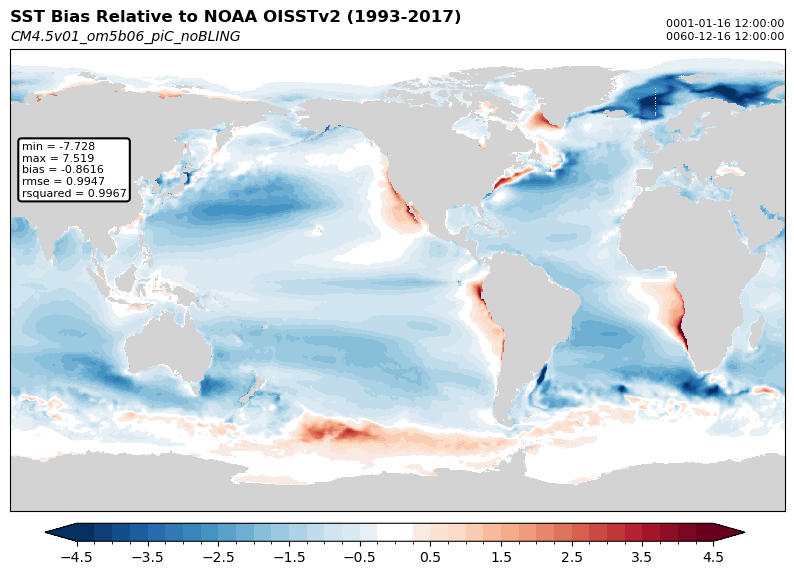

In [20]:
# Setup plot
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1, facecolor="lightgray")

# Definie geolon and geolat for plotting (use corners!)
x = ds.geolon_c
y = ds.geolat_c

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

# Run pcolormesh
cb = plt.pcolormesh(x,y,model-obs, cmap=cmap, norm=norm)

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(model, obs, ds.areacello)
add_stats_box(ax, stats_str)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["global"] = stats

### Arctic

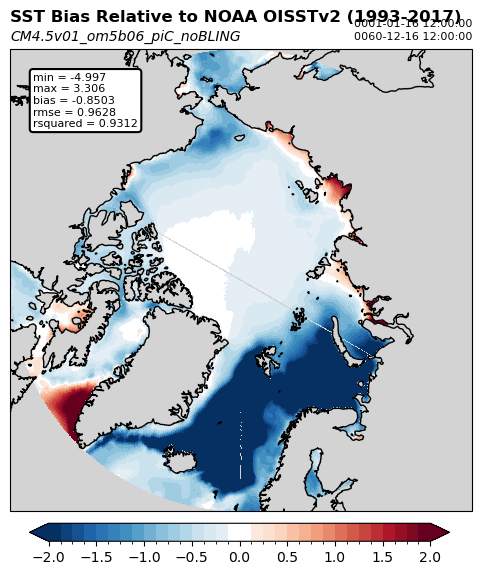

In [21]:
xrange = (-298,61)
yrange = (60.,91.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-2.0,2.125,0.125)

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.NorthPolarStereo())
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.05, y=0.95)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["Arctic"] = stats

### Southern Ocean

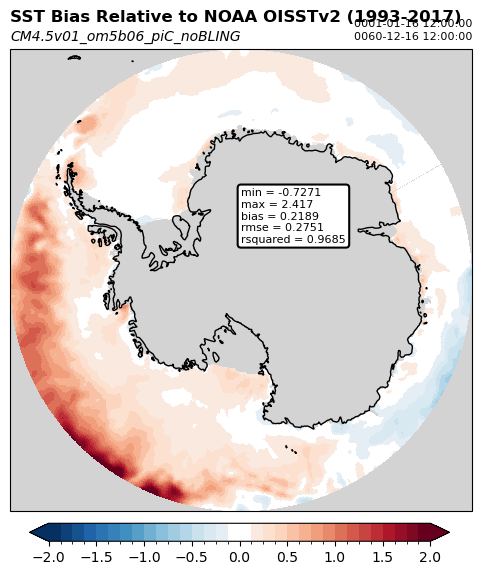

In [22]:
xrange = (-300,60)
yrange = (-60.,-91.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-2.0,2.125,0.125)

fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.SouthPolarStereo())
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.5, y=0.7)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["southern_ocean"] = stats

### Northwest Pacific

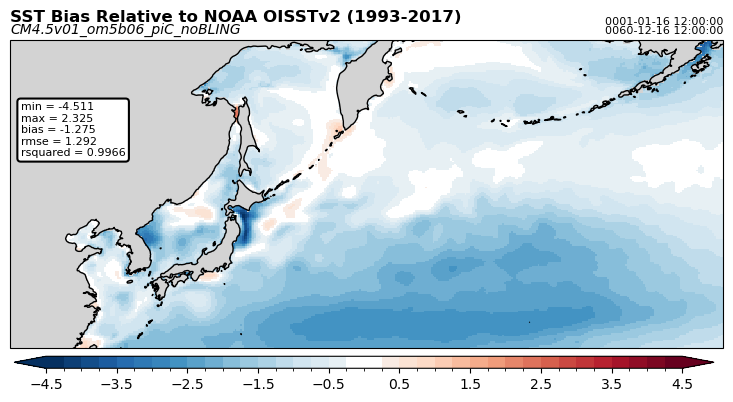

In [23]:
xrange = (-250.,-150.)
yrange = (25.,60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-200))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["Northest_Pacific"] = stats

### Tropical and Subtropical Indo-Pacific

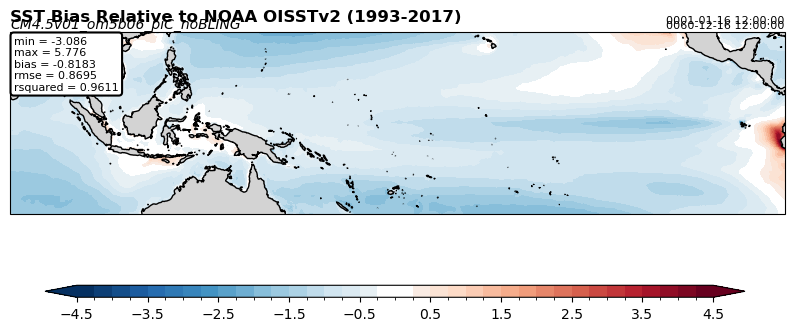

In [24]:
xrange = (-280.,-80.)
yrange = (-23.,23.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-180))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.005, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["TropicalSubtropical_IndoPacific"] = stats

### South Indo-Pacific

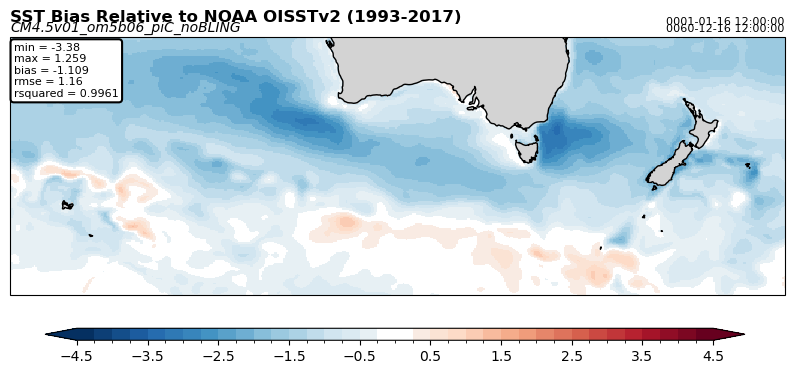

In [25]:
xrange = (-300.,-170.)
yrange = (-25.,-60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-180))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.005, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["south_indo_pacific"] = stats

### North Atlantic 

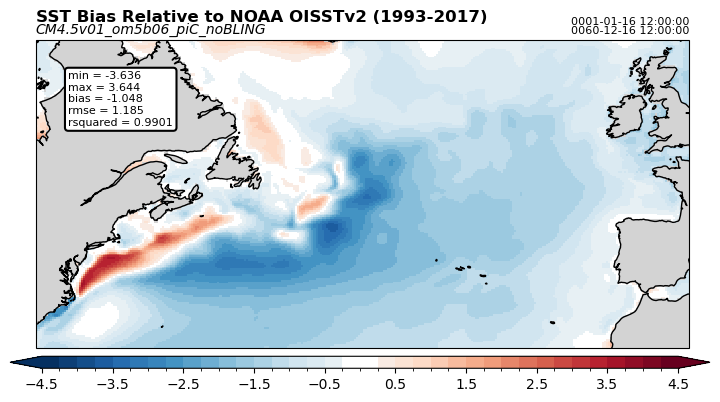

In [26]:
xrange = (-80.,-0.)
yrange = (30.,60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-60))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.05, y=0.9)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["North_Atlantic"] = stats

### South Atlantic

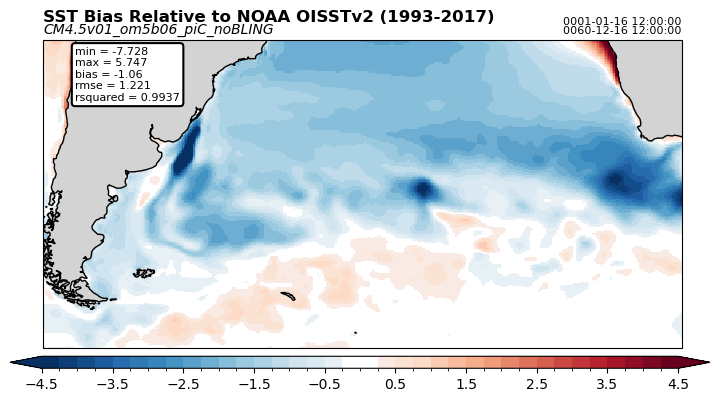

In [27]:
xrange = (-75.,25.)
yrange = (-20.,-60.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-25))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.05, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["South_Atlantic"] = stats

### California Current

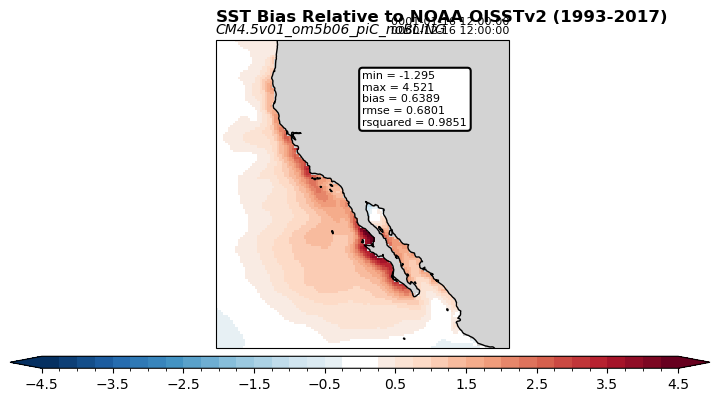

In [28]:
xrange = (-130.,-100.)
yrange = (18.,46.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-115))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.5, y=0.9)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["California_Current"] = stats

### Bengula Current

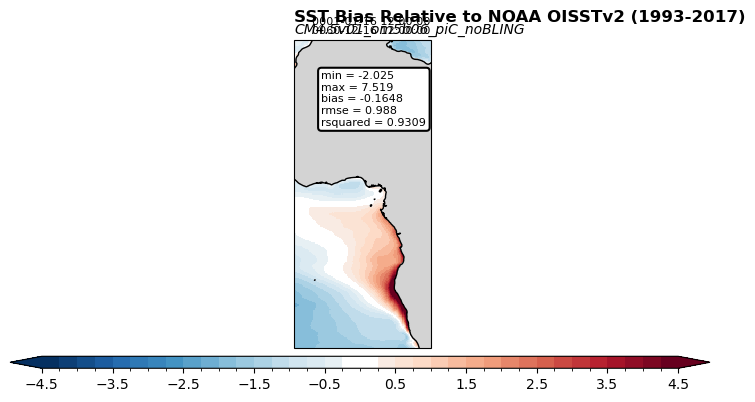

In [29]:
xrange = (-10.,20.)
yrange = (35.,-30.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=5))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.2, y=0.9)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["Bengula_Current"] = stats

### Off the west coast of South America

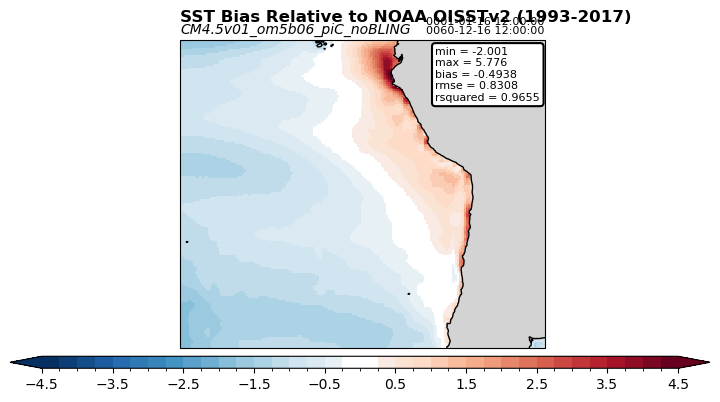

In [30]:
xrange = (-110.,-60.)
yrange = (0.,-40.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-85))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.7, y=0.98)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["offthe_WestCoastSouthAmerica"] = stats

### Carribbean region

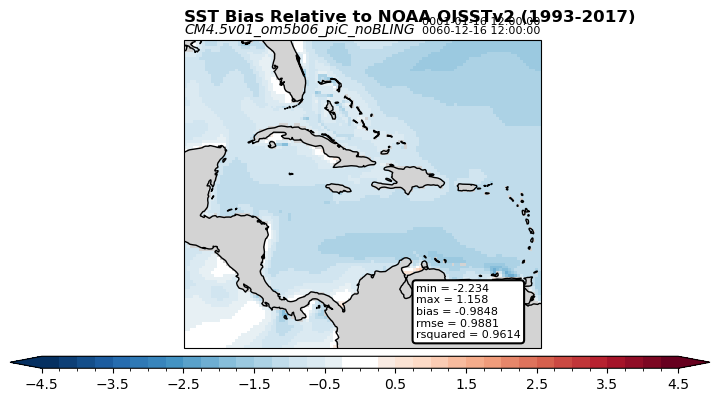

In [31]:
xrange = (-90.,-60.)
yrange = (5.,30.)

_model = momgrid.geoslice.geoslice(model,x=xrange,y=yrange)
_obs = momgrid.geoslice.geoslice(obs,x=xrange,y=yrange)

xq = list((_model.xh.values - 0.5).astype(int))
yq = list((_model.yh.values - 0.5).astype(int))

xq = xq + [xq[-1] + 1]
yq = yq + [yq[-1] + 1]

x = ds.geolon_c.values[yq,:][:,xq]
y = ds.geolat_c.values[yq,:][:,xq]

# Get colormap
cmap, norm, boundaries = gen_levs_and_cmap(-4.5,4.75,0.25)

fig = plt.figure(figsize=(10,4))
ax = plt.subplot(1,1,1, facecolor="lightgray", projection=ccrs.Miller(central_longitude=-60))
cb = ax.pcolormesh(x,y,_model-_obs,transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
ax.coastlines()

# Clean up figure and add labels
set_annotaions(ax)

# Add statistics
stats, stats_str = calculate_stats(_model, _obs, _model.areacello)
add_stats_box(ax, stats_str, x=0.65, y=0.21)

# Add colorbar
add_colorbar(fig, cb, boundaries)

# Save stats
stats_dict["results"]["Carribbean"] = stats

### Write Stats to a File

In [32]:
if not "DORA_EXECUTE" in os.environ.keys():
    import yaml
    yml = yaml.dump(stats_dict)
    with open('oisst_stats.yaml', 'w') as file:
        file.write(yml)
    file.close()
    print(yml)

metadata:
  created: '2024-09-18T13:31:42.503189'
  endtime: '0060-12-16 12:00:00'
  expName: CM4.5v01_om5b06_piC_noBLING
  starttime: '0001-01-16 12:00:00'
results:
  Arctic:
    bias: '-0.8503'
    max: '3.306'
    min: '-4.997'
    rmse: '0.9628'
    rsquared: '0.9312'
  Bengula_Current:
    bias: '-0.1648'
    max: '7.519'
    min: '-2.025'
    rmse: '0.988'
    rsquared: '0.9309'
  California_Current:
    bias: '0.6389'
    max: '4.521'
    min: '-1.295'
    rmse: '0.6801'
    rsquared: '0.9851'
  Carribbean:
    bias: '-0.9848'
    max: '1.158'
    min: '-2.234'
    rmse: '0.9881'
    rsquared: '0.9614'
  North_Atlantic:
    bias: '-1.048'
    max: '3.644'
    min: '-3.636'
    rmse: '1.185'
    rsquared: '0.9901'
  Northest_Pacific:
    bias: '-1.275'
    max: '2.325'
    min: '-4.511'
    rmse: '1.292'
    rsquared: '0.9966'
  South_Atlantic:
    bias: '-1.06'
    max: '5.747'
    min: '-7.728'
    rmse: '1.221'
    rsquared: '0.9937'
  TropicalSubtropical_IndoPacific:
    bias